In [51]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn import preprocessing
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler



sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [52]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

In [53]:
all_cities = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/all_cities.csv',
                   encoding='utf8')

In [54]:
df = all_cities[[col for col in all_cities.columns if col not in ['bhk','neighborhood']]]

In [55]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,price,rest_count,reviews,review_count,room_type,city
0,0,1.0,1.0,0.266061,565,6,2.0,5.0,113.0,10,8,7423,Entire home/apt,paris
1,1,1.0,1.0,0.089208,2340,3,7.0,2.0,79.0,1,2,28620,Entire home/apt,copenhagen


In [56]:
def balanced_stratified_sample(df, col="recommended"):
   
   group_df = df.groupby(col)
   
   minimum_sample_size = group_df.size().min()
   
   new_data = pd.DataFrame()
   
   for group_name, g_df in group_df:
        sample = g_df.sample(minimum_sample_size)
        new_data = pd.concat([new_data, sample])
   
   return pd.DataFrame(new_data)
       
stratified_df = balanced_stratified_sample(df, col="city")   
print "stratified sample: ", stratified_df.groupby("city").size()
print "original sample:", df.groupby("city").size()

stratified sample:  city
barcelona     13875
berlin        13875
copenhagen    13875
paris         13875
rome          13875
dtype: int64
original sample: city
barcelona     13875
berlin        14790
copenhagen    14541
paris         41124
rome          15585
dtype: int64


In [57]:
# stratified_df.drop('Unnamed: 0', axis=1, inplace=True)
stratified_df = stratified_df.reset_index(drop=True)
X = stratified_df[[x for x in stratified_df.columns if x not in ['bhk','city']]]
    
target_classes = stratified_df['city'].unique().tolist()
stratified_df.city = stratified_df.city.map(lambda value: target_classes.index(value))
formula = "city ~ "+' + '.join(X)+' -1'
y, X = patsy.dmatrices(formula, data=stratified_df, return_type='dataframe')
y = y.values.ravel()




In [58]:
# split train if you want
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold

#Xn = StandardScaler().fit_transform(X)

Xc = X - np.mean(X)

Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.33, random_state=42)

#Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size=0.33, random_state=42)

# skf = StratifiedKFold(n_splits=2)
# for train_index, test_index in skf.split(Xn, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     Xn_train, Xn_test = Xn[train_index], Xn[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# model = LogisticRegression()  # <--- non CV/ non k-folds / non-regularization
model = LogisticRegressionCV(cv= 10) # <--- cv = k # folds

model.fit(Xc_train, y_train)

predictions = model.predict(Xc_test)
# #df['predicted_class'] = predictions

# class report
print classification_report(predictions, y_test, target_names=target_classes)

# building coefs
coefs = pd.DataFrame(model.coef_, columns=X.columns)
coefs.index = target_classes
coefs


             precision    recall  f1-score   support

  barcelona       0.72      0.80      0.76      4045
     berlin       0.75      0.76      0.75      4529
 copenhagen       0.94      0.82      0.88      5416
      paris       0.93      0.68      0.79      6153
       rome       0.58      0.96      0.72      2751

avg / total       0.82      0.79      0.79     22894



,room_type[Entire home/apt],room_type[Private room],room_type[Shared room],bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,price,rest_count,reviews,review_count
barcelona,-0.137031,0.137080,-0.000049,0.153551,0.360938,-0.088534,-0.004543,-0.021075,-5.906576e-07,-0.026340,-0.003955,-0.040189,-0.001362,0.000298
berlin,0.017463,-0.016555,-0.000908,-0.015472,-0.000759,-0.000350,0.000919,0.243850,1.463499e-01,0.047191,-0.009685,-0.036063,-0.001305,-0.000056
copenhagen,0.030107,-0.027123,-0.002984,-0.080366,0.166444,-0.124501,0.004720,-0.165310,-1.847901e-06,-0.091838,0.000231,-0.005229,-0.000689,-0.000286
paris,0.145716,-0.152505,0.006789,-0.124925,-0.596464,0.127636,-0.001873,-0.085446,1.497924e-07,0.147733,0.007282,-0.026801,-0.001532,0.000067
rome,-0.094612,0.093493,0.001119,0.103604,-0.028025,0.103597,0.001044,-0.022924,-2.500033e-06,-0.073914,-0.000106,0.026985,0.000834,-0.000046


In [59]:
#model.predict_proba(Xn_test, multi_class=)

In [60]:
print classification_report(predictions, y_test, target_names=target_classes)

             precision    recall  f1-score   support

  barcelona       0.72      0.80      0.76      4045
     berlin       0.75      0.76      0.75      4529
 copenhagen       0.94      0.82      0.88      5416
      paris       0.93      0.68      0.79      6153
       rome       0.58      0.96      0.72      2751

avg / total       0.82      0.79      0.79     22894



In [61]:
bc = coefs[coefs.index == 'barcelona'].T
bc = bc.reset_index()
bc.rename(columns = {'index':'features'}, inplace=True)

br = coefs[coefs.index == 'berlin'].T
br = br.reset_index()
br.rename(columns = {'index':'features'}, inplace=True)

cop = coefs[coefs.index == 'copenhagen'].T
cop = cop.reset_index()
cop.rename(columns = {'index':'features'}, inplace=True)

pr = coefs[coefs.index == 'paris'].T
pr = pr.reset_index()
pr.rename(columns = {'index':'features'}, inplace=True)

ro = coefs[coefs.index == 'rome'].T
ro = ro.reset_index()
ro.rename(columns = {'index':'features'}, inplace=True)




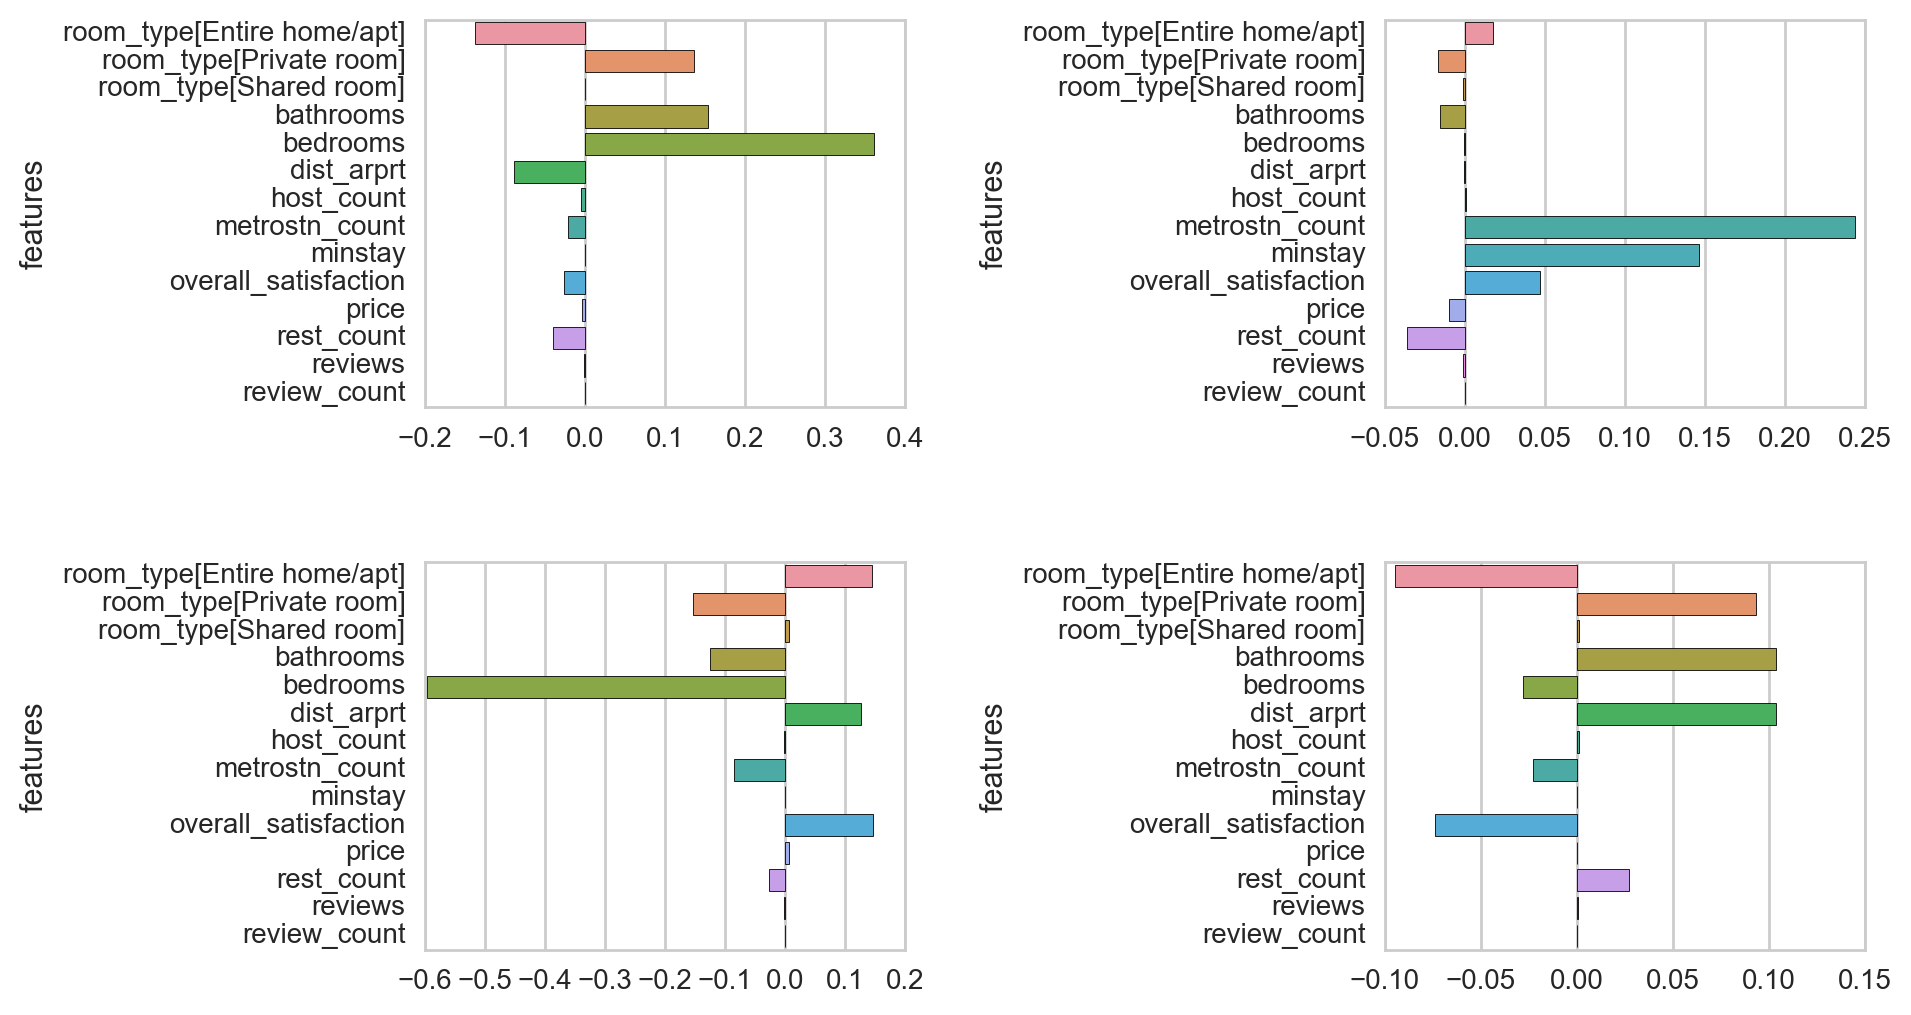

In [62]:
fig, axarray = plt.subplots(2,2, figsize =(6,6))
plt.subplots_adjust(left= 0., bottom=None, right=1.2, top=None,
                  wspace=1, hspace=0.4)

ax1 = axarray[0][0]
ax2 = axarray[0][1]
ax3 = axarray[1][0]
ax4 = axarray[1][1]


sns.barplot(x = bc.barcelona.values, y = bc.features, data=bc, ax =  ax1)
sns.barplot(x = br.berlin.values, y = br.features, data=br, ax =  ax2)
sns.barplot(x = pr.paris.values, y = pr.features, data=pr, ax =  ax3)
sns.barplot(x = ro.rome.values, y = ro.features, data=ro, ax =  ax4)

#ax1.title(object = 'barcelona_features')

plt.show()

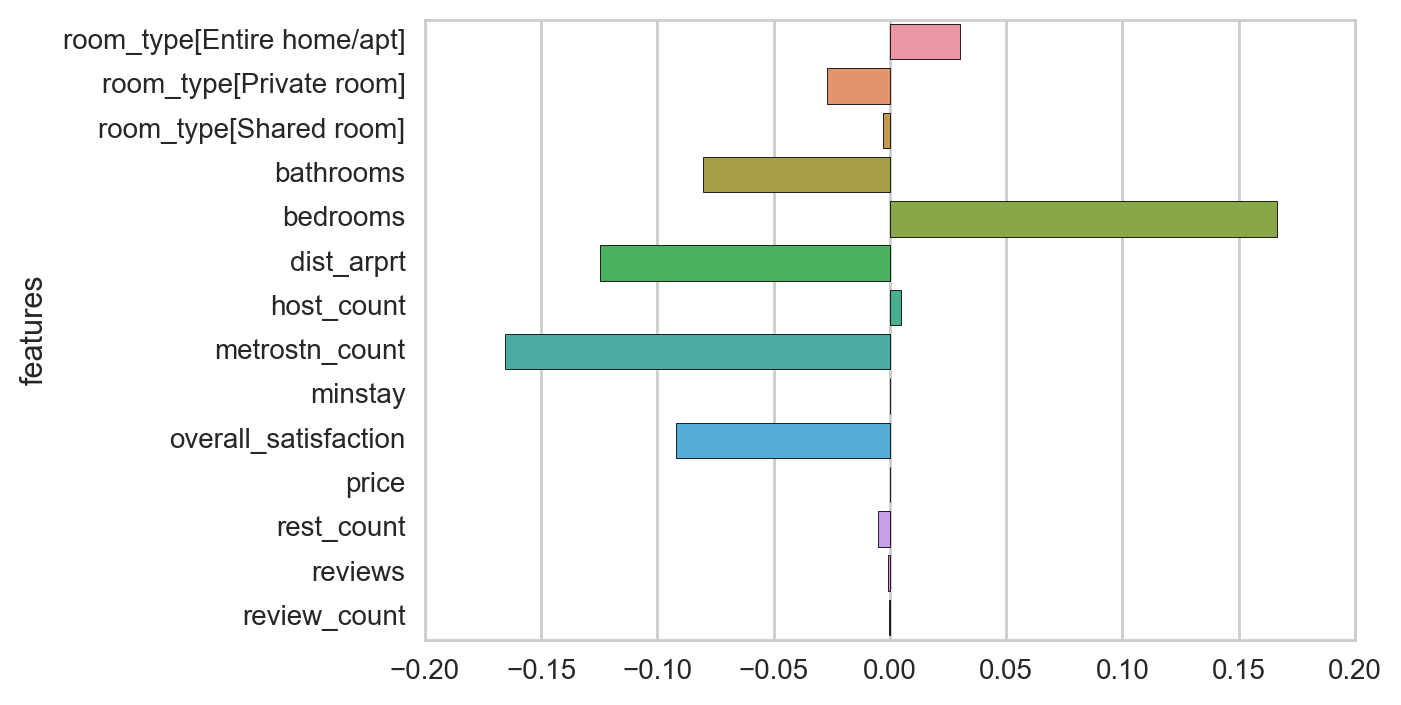

In [63]:
sns.barplot(x = cop.copenhagen.values, y = cop.features, data=cop)
